In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns


import glob, os
import torch
import numpy as np

import config_matplotlib
config_matplotlib.config_matplotlib()


registered cmap: seaborn_cubehelix



In [2]:
summary_yaml = '/pscratch/sd/z/zhantao/inxs_steering_production/benchmarks/summary.yaml'

In [3]:
import yaml

with open(summary_yaml, 'r') as file:
    summary_dict = yaml.safe_load(file)


In [4]:
print(summary_dict['simulation']['poisson_scaled'])

['lkhd_poisson_scaled_True_steps_50_20240328-1510', 'lkhd_poisson_scaled_True_steps_50_20240329-0010', 'lkhd_poisson_scaled_True_steps_50_20240329-1417', 'lkhd_poisson_scaled_True_steps_50_20240330-1212']


In [5]:
mean_preds = []
true_values = []
sample_ids = []
maes = []
maes_half_way = []


all_measured_angle_steps = []
all_measured_angles = []
all_measured_angles_sample_indices = []

idx_count = 0
for path in summary_dict['simulation']['poisson_scaled']:
    pt_flist = glob.glob(os.path.join(summary_dict['path'], path, '*.pt'))
    pt_indices = sorted([int(_.split('/')[-1].split('.')[0]) for _ in pt_flist])


    for i_idx, _idx in enumerate(pt_indices):
        _pt = torch.load(os.path.join(summary_dict['path'], path, f'{_idx}.pt'))
        # print(_pt.keys())
        _mean_preds = (_pt['positions'] * _pt['weights'].unsqueeze(-1)).sum(dim=-2) / _pt['weights'].sum(dim=-1).unsqueeze(-1)
        _maes = (_mean_preds - _pt['true_params'][None])[-1,None].abs()
        
        mean_preds.append(_mean_preds.unsqueeze(0))
        maes.append(_maes)
        maes_half_way.append((_mean_preds - _pt['true_params'][None])[25,None].abs())
        sample_ids.append(_idx)
        true_values.append(_pt['true_params'])

        all_measured_angle_steps += np.linspace(0,50,50).tolist()
        all_measured_angles += _pt['measured_angles'].numpy().reshape(-1).tolist()
        all_measured_angles_sample_indices += [idx_count] * 50
        idx_count += 1


all_measured_angles = np.array(all_measured_angles)
all_measured_angles[all_measured_angles > 180] -= 360

maes = torch.vstack(maes).numpy()
maes_half_way = torch.vstack(maes_half_way).numpy()
mean_preds = torch.vstack(mean_preds).numpy()
sample_ids = torch.tensor(sample_ids).numpy()
true_values = torch.vstack(true_values).numpy()

In [6]:
mae_sorted_quartiles_idx = np.split(np.argsort(maes.mean(axis=-1)), 4)
mae_sorted_quartiles = np.split(np.sort(maes.mean(axis=-1)), 4)

mae_halfway_sorted_quartiles_idx = np.split(np.argsort(maes_half_way.mean(axis=-1)), 4)
mae_halfway_sorted_quartiles = np.split(np.sort(maes_half_way.mean(axis=-1)), 4)


In [7]:
mae_halfway_sorted_quartiles_idx

[array([163, 187, 204,  94,  99, 189,  55, 144,  82, 128,  13, 101,  56,
         24, 154, 172,  22,  65,  41, 221, 215, 198, 213,  67, 229,  88,
        219, 224, 223,  33,  42, 188, 116,  50,  81, 131, 236, 176,  30,
        197, 104,  35, 153, 103, 177, 159,  69, 214,  84,   8,  95, 110,
        129,  27, 137,  93, 142,  57, 210, 230]),
 array([164,  73,  39, 232, 237, 170, 151, 234, 102,  52, 175,  68, 183,
         31, 114, 150, 193,  80, 120, 207, 155, 138, 201, 174, 117,   9,
        169,  18,  87,  54, 161,   1,  90,  91,  71,   7,  60, 211, 185,
         11, 109,  43,  44, 209, 121, 100, 192,  20,  17,  78, 160,  92,
        191, 147,  28, 206, 222,  77,  14, 235]),
 array([  6,  49, 149, 212, 133,  98,   5,  45, 143, 123, 200, 162, 226,
        220, 127,  36, 125, 115,  26, 140,  40, 148, 111,  61, 202, 122,
         23,   0,  62, 105,   2, 158,  37,  29,  97, 130, 107,  76,   3,
        113, 225, 218, 165,  96, 190,  58, 208,  63, 134, 146,  48, 181,
        108,  72, 217, 1

[Text(0, 0.0, '0'),
 Text(0, 3.0, '3'),
 Text(0, 6.0, '6'),
 Text(0, 9.0, '9'),
 Text(0, 12.0, '12'),
 Text(0, 15.0, '15'),
 Text(0, 18.0, '18')]

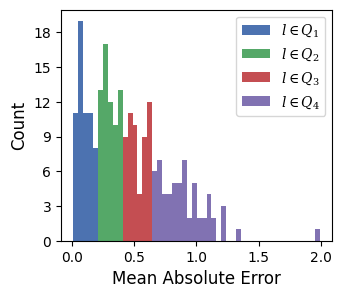

In [8]:

# fig, ax = plt.subplots(1,1)
# ax.hist(maes.mean(axis=-1), bins=60)
# mae_sorted_quartiles = np.split(np.sort(maes.mean(axis=-1)), 4)

fig, ax = plt.subplots(1,1,figsize=(3.5, 3))
# n, bins, patches = ax.hist(np.linalg.norm(maes, axis=-1), bins=50)
n, bins, patches = ax.hist(maes.mean(axis=-1), bins=50)

bin_centers = 0.5 * (bins[:-1] + bins[1:])

start_ids = []
for i in range(4):
    start = np.where(bin_centers > mae_sorted_quartiles[i].min())[0][0]
    start_ids.append(start)
    for patch in patches[start:]:
        patch.set_facecolor(f'C{i}')
        
# Add legend for each color
legend_labels = [fr'$l\in Q_{_j+1}$' for _j in range(4)]
legend_patches = [patches[start] for start in start_ids]
ax.legend(legend_patches, legend_labels)

ax.set_xlabel('Mean Absolute Error')
ax.set_ylabel('Count')
ax.set_yticks(np.arange(0, np.ceil(n.max())+1, step=3))
ax.set_yticklabels(np.arange(0, np.ceil(n.max())+1, step=3).astype('int'))

# fig.savefig('figures/siml_benchmark_hist.pdf', bbox_inches='tight')

In [9]:
relative_idx_of_interest = 12

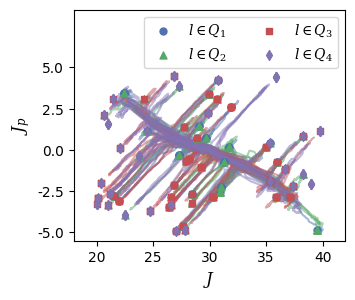

In [10]:
N_samp = mean_preds.shape[1]

N_samp_interp = 100

step = 20

markers = ['o', '^', 's', 'd']
fig, ax = plt.subplots(1,1,figsize=(3.5, 3))
for _j in range(4):
    
    np.random.seed(9)
    rdn_idx = np.random.choice(mae_sorted_quartiles_idx[_j], len(mae_sorted_quartiles_idx[_j]), replace=False)
    for _idx in rdn_idx:
        
        ax.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C{_j}', alpha=0.5, zorder=1)
        
        ax.scatter(true_values[_idx,0], true_values[_idx,1], 
                   color=f'C{_j}', marker=markers[_j], zorder=10, s=25,
                   label=fr'$l\in Q_{_j+1}$' if _idx==rdn_idx[0] else None)
        
ax.set_xlabel('$J$')
ax.set_ylabel('$J_{p}$')
ax.set_xlim(18, 42)
ax.set_xticks(np.linspace(20, 40, 5, dtype=int))
ax.set_xticklabels(np.linspace(20, 40, 5, dtype=int))
ax.set_ylim(-5.5, 8.5)
ax.set_yticks(np.linspace(-5, 5, 5))
ax.set_yticklabels(np.linspace(-5, 5, 5))
ax.legend(loc='upper right', ncol=2)

# fig.savefig('figures/siml_benchmark_trajs.pdf', bbox_inches='tight')


In [11]:

unique_ids = list(set(sorted(sample_ids.tolist())))
demo_ids = unique_ids[0]

In [12]:
from sklearn.neighbors import KernelDensity
import numpy as np
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(_pt['positions'][-1], sample_weight=_pt['weights'][-1])
J, Jp = np.meshgrid(np.linspace(20, 40, 401), np.linspace(-5, 5, 201))
param_grid = np.concatenate([J[..., None], Jp[..., None]], axis=-1)
log_density = kde.score_samples(param_grid.reshape(-1, 2)).reshape(J.shape)

/global/homes/z/zhantao/.conda/envs/ddpm3/lib/python3.11/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


In [13]:
def kde_particle_to_grid(positions, weights, kde_kwargs=None):
    if kde_kwargs is None:
        kde_kwargs = {'kernel': 'gaussian', 'bandwidth': 0.5}
    kde = KernelDensity(**kde_kwargs).fit(positions, sample_weight=weights)
    J, Jp = np.meshgrid(np.linspace(20, 40, 401), np.linspace(-5, 5, 201))
    param_grid = np.concatenate([J[..., None], Jp[..., None]], axis=-1)
    log_density = kde.score_samples(param_grid.reshape(-1, 2)).reshape(J.shape)
    density = np.exp(log_density)
    return density, J, Jp

In [14]:
demo_idx = sample_ids[relative_idx_of_interest]

demo_pt = torch.load(os.path.join(
    summary_dict['path'], 
    summary_dict['simulation']['gaussian_0.1_scaled'][-1], 
    f'{demo_idx}.pt'))

In [15]:
demo_pt.keys()

dict_keys(['means', 'positions', 'weights', 'measured_angles', 'background_signal_factors', 'utility', 'likelihood', 'true_params'])

Text(0, 0.5, 'Measured Angle (deg)')

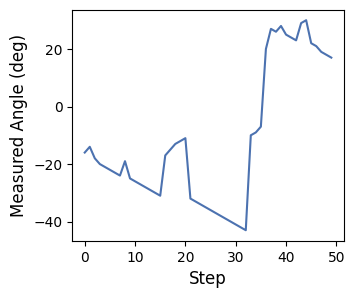

In [16]:
_measured_angles = demo_pt['measured_angles']
_measured_angles[_measured_angles > 180] -= 360

# idx_of_interest = 27

fig, ax = plt.subplots(1,1, figsize=(3.5, 3))
ax.plot(_measured_angles)
ax.set_xlabel('Step')
ax.set_ylabel('Measured Angle (deg)')
# plt.plot(np.abs(_measured_angles))
# plt.scatter(idx_of_interest, _measured_angles[idx_of_interest])

# fig.savefig('figures/siml_benchmark_measured_angles.pdf', bbox_inches='tight')

In [17]:
import sys
sys.path.append('..')

from inxss.utils_visualization import visualize_utility


In [18]:
idx_prior = 2
kde_prior, J, Jp  = kde_particle_to_grid(demo_pt['positions'][idx_prior],   demo_pt['weights'][idx_prior])
kde_poste, _, _  = kde_particle_to_grid(demo_pt['positions'][idx_prior+1], demo_pt['weights'][idx_prior+1])
kde_lkhd ,  _, _ = kde_particle_to_grid(demo_pt['positions'][idx_prior],   demo_pt['likelihood'][idx_prior])


/global/homes/z/zhantao/.conda/envs/ddpm3/lib/python3.11/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/global/homes/z/zhantao/.conda/envs/ddpm3/lib/python3.11/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


In [19]:

kde_prior = (kde_prior - kde_prior.min()) / (kde_prior.max() - kde_prior.min())
kde_lkhd  = (kde_lkhd  - kde_lkhd.min()) / (kde_lkhd.max() - kde_lkhd.min())
kde_poste = (kde_poste - kde_poste.min()) / (kde_poste.max() - kde_poste.min())

In [20]:

idx_prior_sec = 38
kde_prior_sec, J_grid, Jp_grid  = kde_particle_to_grid(demo_pt['positions'][idx_prior_sec],   demo_pt['weights'][idx_prior_sec])
kde_poste_sec, _, _  = kde_particle_to_grid(demo_pt['positions'][idx_prior_sec+1], demo_pt['weights'][idx_prior_sec+1])
kde_lkhd_sec ,  _, _ = kde_particle_to_grid(demo_pt['positions'][idx_prior_sec],   demo_pt['likelihood'][idx_prior_sec])

/global/homes/z/zhantao/.conda/envs/ddpm3/lib/python3.11/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/global/homes/z/zhantao/.conda/envs/ddpm3/lib/python3.11/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/global/homes/z/zhantao/.conda/envs/ddpm3/lib/python3.11/site-packages/sklearn/neighbors/_kde.py:272: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


In [21]:

kde_prior_sec = (kde_prior_sec - kde_prior_sec.min()) / (kde_prior_sec.max() - kde_prior_sec.min())
kde_lkhd_sec  = (kde_lkhd_sec  - kde_lkhd_sec.min()) / (kde_lkhd_sec.max() - kde_lkhd_sec.min())
kde_poste_sec = (kde_poste_sec - kde_poste_sec.min()) / (kde_poste_sec.max() - kde_poste_sec.min())

(0.7, 1.05)

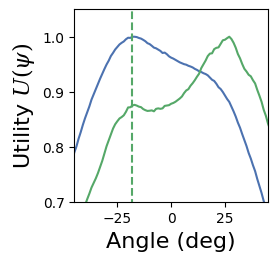

In [22]:
# fig = plt.figure(figsize=(2.5, 2.5))
# ax = fig.add_subplot(111, projection='polar')
# visualize_utility(np.arange(360), demo_pt['utility'][0], ax=ax)
# fig.savefig('figures/siml_benchmark_util_inset.pdf', bbox_inches='tight')

util = demo_pt['utility'][idx_prior]
util = util / util.max()

util_sec = demo_pt['utility'][idx_prior_sec]
util_sec = util_sec / util_sec.max()
# util = (util - util.min()) / (util.max() - util.min())

angles = np.arange(360)
angles[angles>180] -= 360

util     = np.concatenate([util[angles<0],     util[angles>=0]],     axis=0)
util_sec = np.concatenate([util_sec[angles<0], util_sec[angles>=0]], axis=0)
angles   = np.concatenate([angles[angles<0],   angles[angles>=0]],   axis=0)

# angles = np.roll(angles, -1)
# util = np.roll(util, -1)

fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
ax.plot(angles, util)
ax.plot(angles, util_sec)
ax.vlines(angles[util.argmax()], -1, 2, color='C1', linestyle='--')
ax.set_xlabel('Angle (deg)', fontdict={'size': 16})
ax.set_ylabel(r'Utility $U(\psi)$', fontdict={'size': 16})
ax.set_xlim([-45, 45])
ax.set_ylim([0.7, 1.05])
# ax.set_xticks(np.linspace(-180, 180, 5))
# ax.set_ylim([-0.05, 1.05])
# fig.savefig('figures/siml_benchmark_util_inset.pdf', bbox_inches='tight', transparent=True)

In [23]:
demo_pt['true_params']

tensor([21.0442, -3.3076], dtype=torch.float64)

In [24]:
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

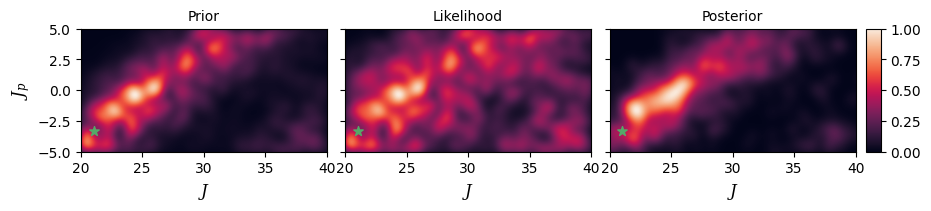

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharey=True, gridspec_kw={'wspace': 0.075})

cmap = plt.get_cmap('seaborn_cubehelix')
cmap = sns.color_palette("rocket", as_cmap=True)


im0 = ax[0].imshow(kde_prior, origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
ax[0].set_title('Prior')
ax[0].set_xlabel('$J$')
ax[0].set_ylabel('$J_{p}$')
ax[0].scatter(*demo_pt['true_params'], s=50, marker='*', color='C1')
ax[0].set_xlim(20, 40)
ax[0].set_ylim(-5, 5)

im1 = ax[1].imshow(kde_lkhd, origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
ax[1].scatter(*demo_pt['true_params'], s=50, marker='*', color='C1')
ax[1].set_title('Likelihood')
ax[1].set_xlabel('$J$')
ax[1].set_xlim(20, 40)
ax[1].set_ylim(-5, 5)

im2 = ax[2].imshow(kde_poste, origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
ax[2].scatter(*demo_pt['true_params'], s=50, marker='*', color='C1')
ax[2].set_title('Posterior')
ax[2].set_xlabel('$J$')
ax[2].set_xlim(20, 40)
ax[2].set_ylim(-5, 5)

fraction_positions = ax[2].get_position()

# Add colorbar
cbar_ax = fig.add_axes([
    fraction_positions.p1[0]+0.01, fraction_positions.p0[1], 
    0.015, fraction_positions.height])

fig.colorbar(im2, cax=cbar_ax)


fig.savefig('figures/siml_benchmark_bayesian_demo.pdf', bbox_inches='tight')

In [26]:
demo_pt_mean = (demo_pt['positions'] * demo_pt['weights'].unsqueeze(-1)).sum(dim=-2) / demo_pt['weights'].sum(dim=-1).unsqueeze(-1)

In [27]:
weights_sq_sum = torch.sum(demo_pt['weights']**2, dim=1)
normalization_factor = 1 / (1 - weights_sq_sum + torch.finfo(demo_pt['weights'].dtype).eps)
var = normalization_factor.unsqueeze(-1) * torch.sum(demo_pt['weights'].unsqueeze(-1) * (demo_pt['positions'] - demo_pt['means'].unsqueeze(1))**2, dim=1)
std = var.sqrt()

Text(0, 0.5, 'Parameter Value')

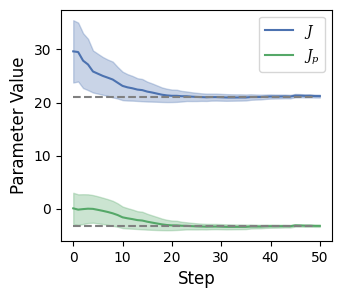

In [28]:
fig, ax = plt.subplots(1,1, figsize=(3.5, 3))
ax.plot(np.arange(demo_pt['means'].shape[0]), demo_pt['means'])
ax.fill_between(np.arange(demo_pt['means'].shape[0]), 
                (demo_pt['means'] - std)[:,0], 
                (demo_pt['means'] + std)[:,0], alpha=0.3, color='C0')
ax.fill_between(np.arange(demo_pt['means'].shape[0]), 
                (demo_pt['means'] - std)[:,1], 
                (demo_pt['means'] + std)[:,1], alpha=0.3, color='C1')
ax.hlines(demo_pt['true_params'], 0, 49, color='gray', linestyle='--')
# ax.plot([idx_prior, idx_prior+1], [demo_pt_mean[i] for i in [idx_prior,idx_prior+1]], 'o', color='C2')

ax.legend(['$J$', '$J_{p}$'])
ax.set_xlabel('Step')
ax.set_ylabel('Parameter Value')
# fig.savefig('figures/siml_benchmark_mean_hist.pdf', bbox_inches='tight')

Bbox(x0=0.6400819672131146, y0=0.77, x1=0.8600819672131146, y1=0.88)


/tmp/ipykernel_1884170/2262344294.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


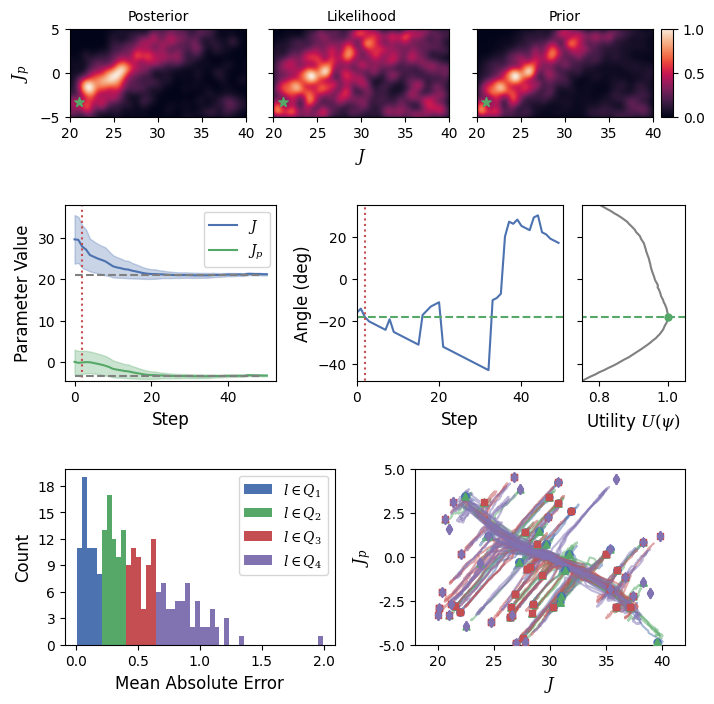

In [29]:
# fig = plt.figure(figsize=(8, 8))
# gs = fig.add_gridspec(3, 11, wspace=0.6, hspace=0.6, height_ratios=[.5, 1, 1])

# # histogram
# ax_hist = fig.add_subplot(gs[-1, :5])

# n, bins, patches = ax_hist.hist(maes.mean(axis=-1), bins=50)
# bin_centers = 0.5 * (bins[:-1] + bins[1:])
# start_ids = []
# for i in range(4):
#     start = np.where(bin_centers > mae_sorted_quartiles[i].min())[0][0]
#     start_ids.append(start)
#     for patch in patches[start:]:
#         patch.set_facecolor(f'C{i}')
        
# # Add legend for each color
# legend_labels = [fr'$l\in Q_{_j+1}$' for _j in range(4)]
# legend_patches = [patches[start] for start in start_ids]
# ax_hist.legend(legend_patches, legend_labels)

# ax_hist.set_xlabel('Mean Absolute Error')
# ax_hist.set_ylabel('Count')
# ax_hist.set_yticks(np.arange(0, np.ceil(n.max())+1, step=3))
# ax_hist.set_yticklabels(np.arange(0, np.ceil(n.max())+1, step=3).astype('int'))

# # trajectory
# ax = fig.add_subplot(gs[-1, 6:])
# for _j in range(4):
#     np.random.seed(9)
#     rdn_idx = np.random.choice(mae_sorted_quartiles_idx[_j], len(mae_sorted_quartiles_idx[_j]), replace=False)
#     for _idx in rdn_idx:
#         ax.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C{_j}', alpha=0.5, zorder=1)
#         ax.scatter(true_values[_idx,0], true_values[_idx,1], 
#                    color=f'C{_j}', marker=markers[_j], zorder=10, s=25,
#                    label=fr'$l\in Q_{_j+1}$' if _idx==rdn_idx[0] else None)
# ax.set_xlabel('$J$')
# ax.set_ylabel('$J_{p}$')
# ax.set_xlim(18, 42)
# ax.set_xticks(np.linspace(20, 40, 5, dtype=int))
# ax.set_xticklabels(np.linspace(20, 40, 5, dtype=int))
# ax.set_ylim(-5, 5)
# ax.set_yticks(np.linspace(-5, 5, 5))
# ax.set_yticklabels(np.linspace(-5, 5, 5))
# # ax.legend(loc='upper right', ncol=2)


# sub_gs = gs[1, 5:].subgridspec(1, 2, wspace=0.125, width_ratios=[1, 0.5])
# # mean value history
# ax_param = fig.add_subplot(gs[1,:4])
# ax_param.plot(np.arange(demo_pt['means'].shape[0]), demo_pt['means'])
# # ax.scatter([idx_prior, idx_prior], [demo_pt['means'][idx_prior,0], demo_pt['means'][idx_prior,1]], marker='o', color='C2', zorder=10, s=25)
# ax_param.vlines(idx_prior, -5, 40, color='C2', linestyle=':')
# ax_param.fill_between(np.arange(demo_pt['means'].shape[0]), 
#                 (demo_pt['means'] - std)[:,0], 
#                 (demo_pt['means'] + std)[:,0], alpha=0.3, color='C0')
# ax_param.fill_between(np.arange(demo_pt['means'].shape[0]), 
#                 (demo_pt['means'] - std)[:,1], 
#                 (demo_pt['means'] + std)[:,1], alpha=0.3, color='C1')
# ax_param.hlines(demo_pt['true_params'], 0, 49, color='gray', linestyle='--')
# # ax.plot([idx_prior, idx_prior+1], [demo_pt_mean[i] for i in [idx_prior,idx_prior+1]], 'o', color='C2')
# ax_param.legend(['$J$', '$J_{p}$'])
# ax_param.set_xlabel('Step')
# ax_param.set_ylabel('Parameter Value')
# ax_param.set_ylim([-4.5, 38])

# # measured angle
# ax = fig.add_subplot(sub_gs[0])
# ax.plot(_measured_angles)
# ax.vlines(idx_prior, -100, 100, color='C2', linestyle=':')
# ax.hlines(angles[util.argmax()], 0, 50, color='C1', linestyle='--')
# ax.set_xlabel('Step')
# ax.set_xlim([0, 50])
# ax.set_ylabel('Angle (deg)')
# ax.set_yticks([-40, -20, 0, 20])
# ax.set_ylim([_measured_angles.min()-5, _measured_angles.max()+5])

# ax = fig.add_subplot(sub_gs[1])
# ax.plot(util, angles, color='gray')
# ax.plot(util[util.argmax()], angles[util.argmax()], 'o', color='C1', markersize=5)
# ax.hlines(angles[util.argmax()], 0, 2, color='C1', linestyle='--')
# # ax.vlines(angles[util.argmax()], -1, 2, color='C1', linestyle='--')
# # ax.set_xlabel('Angle (deg)')
# ax.set_xlabel(r'Utility $U(\psi)$')
# ax.set_xlim([0.75, 1.05])
# ax.set_yticks([-40, -20, 0, 20])
# ax.set_yticklabels([])
# ax.set_ylim([_measured_angles.min()-5, _measured_angles.max()+5])

# # probability density
# # ax = fig.add_subplot(gs[2, :]
# # )

# sub_gs = gs[0, :].subgridspec(1, 4, wspace=0.125, width_ratios=[1, 1, 1, 0.05])

# ax_prior = fig.add_subplot(sub_gs[0, 2])
# im0 = ax_prior.imshow(kde_prior, origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
# ax_prior.set_title('Prior')
# ax_prior.set_yticklabels([])
# # ax.set_xlabel('$J$')
# ax_prior.scatter(*demo_pt['true_params'], s=50, marker='*', color='C1')
# ax_prior.set_xlim(20, 40)
# ax_prior.set_ylim(-5, 5)

# ax = fig.add_subplot(sub_gs[0, 1])
# im1 = ax.imshow(kde_lkhd, origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
# ax.scatter(*demo_pt['true_params'], s=50, marker='*', color='C1')
# ax.set_title('Likelihood')
# ax.set_xlabel('$J$')
# ax.set_xlim(20, 40)
# ax.set_ylim(-5, 5)
# ax.set_yticklabels([])

# ax_posterior = fig.add_subplot(sub_gs[0, 0])
# im2 = ax_posterior.imshow(kde_poste, origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
# ax_posterior.scatter(*demo_pt['true_params'], s=50, marker='*', color='C1')
# ax_posterior.set_title('Posterior')
# # ax.set_xlabel('$J$')
# ax_posterior.set_xlim(20, 40)
# ax_posterior.set_ylim(-5, 5)
# ax_posterior.set_ylabel('$J_{p}$')

# fig.align_ylabels([ax_posterior, ax_param, ax_hist])
# fig.tight_layout()

# frac_pos = ax_prior.get_position(False)
# print(frac_pos)

# # Add colorbar
# cbar_ax = fig.add_axes([
#     frac_pos.x1+0.01, frac_pos.y0, 
#     0.015, frac_pos.y1-frac_pos.y0])

# fig.colorbar(im2, cax=cbar_ax)

# # fig.savefig('figures/siml_benchmark_summary.pdf', bbox_inches='tight')

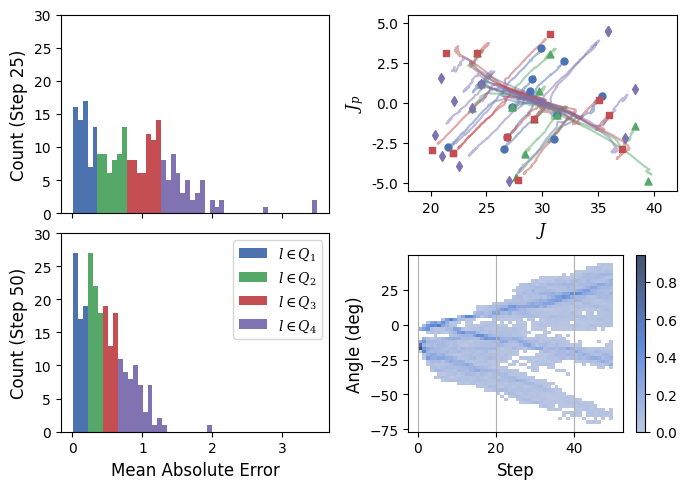

In [33]:
fig = plt.figure(figsize=(7, 5))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

sub_gs = gs[:,0].subgridspec(2, 1, hspace=0.1)
# histogram
ax_hist = fig.add_subplot(sub_gs[0, 0])

n, bins, patches = ax_hist.hist(maes_half_way.mean(axis=-1), bins=50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
start_ids = []
for i in range(4):
    start = np.where(bin_centers > mae_halfway_sorted_quartiles[i].min())[0][0]
    start_ids.append(start)
    for patch in patches[start:]:
        patch.set_facecolor(f'C{i}')
        
# Add legend for each color
legend_labels = [fr'$l\in Q_{_j+1}$' for _j in range(4)]
legend_patches = [patches[start] for start in start_ids]
# ax_hist.legend(legend_patches, legend_labels)

# ax_hist.set_xlabel('Mean Absolute Error')
ax_hist.set_xticklabels([])
ax_hist.set_ylabel('Count (Step 25)')
# ax_hist.set_yticks(np.arange(0, np.ceil(n.max())+1, step=3))
# ax_hist.set_yticklabels(np.arange(0, np.ceil(n.max())+1, step=3).astype('int'))

ax_hist.set_ylim([0, 30])


# histogram
ax_hist2 = fig.add_subplot(sub_gs[1, 0])


n, bins, patches = ax_hist2.hist(maes.mean(axis=-1), bins=int(maes.mean(axis=-1).max() / maes_half_way.mean(axis=-1).max() * 50))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
start_ids = []
for i in range(4):
    start = np.where(bin_centers > mae_sorted_quartiles[i].min())[0][0]
    start_ids.append(start)
    for patch in patches[start:]:
        patch.set_facecolor(f'C{i}')
        
# Add legend for each color
legend_labels = [fr'$l\in Q_{_j+1}$' for _j in range(4)]
legend_patches = [patches[start] for start in start_ids]
ax_hist2.legend(legend_patches, legend_labels)

ax_hist2.set_xlabel('Mean Absolute Error')
ax_hist2.set_ylabel('Count (Step 50)')
# ax_hist2.set_yticks(np.arange(0, np.ceil(n.max())+1, step=3))
# ax_hist2.set_yticklabels(np.arange(0, np.ceil(n.max())+1, step=3).astype('int'))
ax_hist2.set_ylim([0, 30])
ax_hist2.set_xticks(ax_hist.get_xticks()) #set y ticks of first subplot the same as
                                         #x ticks of last subplot
ax_hist2.set_xlim(ax_hist.get_xlim()) #set the y lim of first subplot the same 
                                     #as x lim of last subplot      

# trajectory
ax = fig.add_subplot(gs[0, 1])
for _j in range(4):
    np.random.seed(9)
    rdn_idx = np.random.choice(mae_sorted_quartiles_idx[_j], len(mae_sorted_quartiles_idx[_j])//5, replace=False)
    for _idx in rdn_idx:
        ax.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C{_j}', alpha=0.5, zorder=1)
        ax.scatter(true_values[_idx,0], true_values[_idx,1], 
                   color=f'C{_j}', marker=markers[_j], zorder=10, s=25,
                   label=fr'$l\in Q_{_j+1}$' if _idx==rdn_idx[0] else None)
ax.set_xlabel('$J$')
ax.set_ylabel('$J_{p}$')
ax.set_xlim(18, 42)
ax.set_xticks(np.linspace(20, 40, 5, dtype=int))
ax.set_xticklabels(np.linspace(20, 40, 5, dtype=int))
ax.set_ylim(-5.5, 5.5)
ax.set_yticks(np.linspace(-5, 5, 5))
ax.set_yticklabels(np.linspace(-5, 5, 5));
# ax.legend(loc='upper right', ncol=2)

ax = fig.add_subplot(gs[1, 1])

sns_histplot = sns.histplot(x=np.array(all_measured_angle_steps), y=np.array(all_measured_angles), stat='percent', bins=50, ax=ax, color='C0', cbar=True)
ax.set_xlabel('Step')
ax.set_ylabel('Angle (deg)')
# for i_quat in range(4):
#     idx_angles = np.where(list(map(lambda x: x in mae_halfway_sorted_quartiles_idx[i_quat].tolist(), all_measured_angles_sample_indices)))
#     sns.histplot(x=np.array(all_measured_angle_steps)[idx_angles], y=np.array(all_measured_angles)[idx_angles], bins=50, ax=ax, color=f'C{i_quat}')

ax.xaxis.grid(True, which='both')

fig.tight_layout()

fig.savefig('figures/siml_benchmark_summary.pdf', bbox_inches='tight')

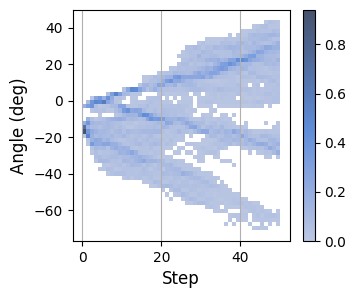

In [38]:
fig, ax = plt.subplots(1,1,figsize=(3.5,3))
sns_histplot = sns.histplot(x=np.array(all_measured_angle_steps), y=np.array(all_measured_angles), stat='percent', bins=50, ax=ax, color='C0', cbar=True)
ax.set_xlabel('Step')
ax.set_ylabel('Angle (deg)')
# for i_quat in range(4):
#     idx_angles = np.where(list(map(lambda x: x in mae_halfway_sorted_quartiles_idx[i_quat].tolist(), all_measured_angles_sample_indices)))
#     sns.histplot(x=np.array(all_measured_angle_steps)[idx_angles], y=np.array(all_measured_angles)[idx_angles], bins=50, ax=ax, color=f'C{i_quat}')

ax.xaxis.grid(True, which='both')
fig.savefig('figures/siml_benchmark_angle_dist.pdf', bbox_inches='tight', transparent=True)

<Axes: xlabel='Step', ylabel='Angle (deg)'>

In [31]:
import hydra
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()

with initialize(config_path="../conf/final"):
    cfg = compose(config_name="config_poisson")
from inxss import PsiMask
from inxss.experiment import SimulatedExperiment
from sklearn.model_selection import train_test_split
idx_plot = 13

spinw_data = torch.load(cfg['paths']['spinw_data_path'])

train_idx, val_test_idx = train_test_split(np.arange(spinw_data['Syy'].shape[0]), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)


grid_info = {
    'h_grid': [-2.0,  2.0, 121],
    'k_grid': [-2.0,  2.0, 121],
    'l_grid': [-10.0, 4.5, 30],
    'w_grid': [ 20.0, 200.0, 91]
}
mask_config = {
    "raw_mask_path": cfg['paths']['raw_mask_path'],
    "memmap_mask_path": cfg['paths']['memmap_mask_path'],
    "grid_info": grid_info,
    "preload": False,
    "build_from_scratch_if_no_memmap": True,
    "global_mask": None
}
psi_mask = PsiMask(**mask_config)

sim_experiment = SimulatedExperiment(
    spinw_data['q_grid'], spinw_data['w_grid'], 
    spinw_data['Syy'][test_idx[idx_plot]], spinw_data['Szz'][test_idx[idx_plot]],
    neutron_flux=1
)
sim_experiment.prepare_experiment(psi_mask.hklw_grid)


/tmp/ipykernel_1319382/819304405.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../conf/final"):


obtained memmap mask name as: mask_h_-2.0_2.0_121_k_-2.0_2.0_121_l_-10.0_4.5_30_w_20.0_200.0_91.npy


In [32]:

mask = psi_mask.load_memmap_mask(_measured_angles[idx_prior])
measured_data = sim_experiment.Sqw * mask

mask_sec = psi_mask.load_memmap_mask(_measured_angles[idx_prior_sec])
measured_data_sec = sim_experiment.Sqw * mask_sec

cmap = sns.color_palette("rocket", as_cmap=True)

In [33]:
idx_prior_sec

38

In [34]:
J_sec_min, J_sec_max = 20, 25
Jp_sec_min, Jp_sec_max = -4.5, -2.
J_ax_idx = np.where((J_grid[0] > J_sec_min) * (J_grid[0] < J_sec_max))[0]
Jp_ax_idx = np.where((Jp_grid[:,0] > Jp_sec_min) * (Jp_grid[:,0] < Jp_sec_max))[0]

/tmp/ipykernel_1319382/3337407415.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Bbox(x0=0.6345340811044003, y0=0.6311356696589747, x1=0.84851164797239, y1=0.7247508551637202)


/tmp/ipykernel_1319382/3337407415.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Bbox(x0=0.6345340811044003, y0=0.7785824781696131, x1=0.84851164797239, y1=0.8721976636743586)


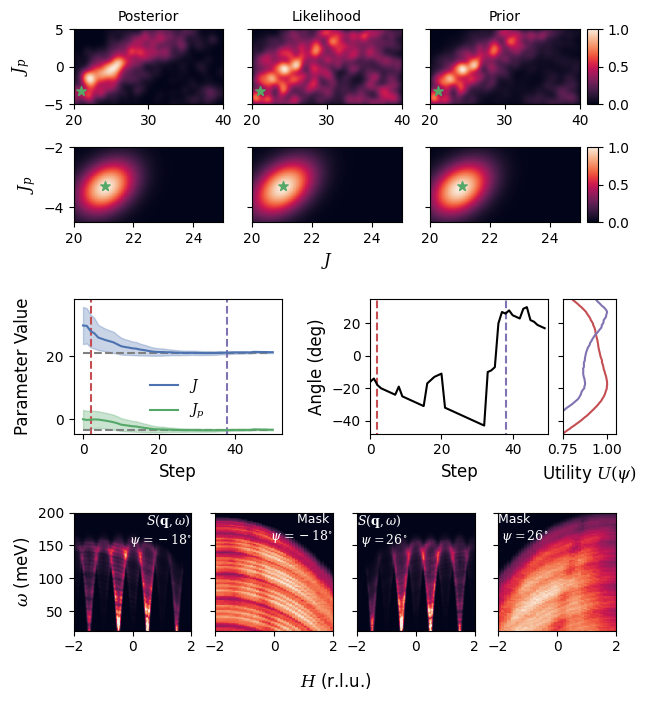

In [38]:
fig = plt.figure(figsize=(7, 8))
gs = fig.add_gridspec(4, 15, wspace=0.6, hspace=0.7, height_ratios=[0.5, 0.5, 1, 1])

# mean value history
ax_param = fig.add_subplot(gs[2,:6])
ax_param.plot(np.arange(demo_pt['means'].shape[0]), demo_pt['means'])
ax_param.vlines(idx_prior, -5, 40, color='C2', linestyle='--')
ax_param.vlines(idx_prior_sec, -5, 40, color='C3', linestyle='--')
ax_param.fill_between(np.arange(demo_pt['means'].shape[0]), 
                (demo_pt['means'] - std)[:,0], 
                (demo_pt['means'] + std)[:,0], alpha=0.3, color='C0')
ax_param.fill_between(np.arange(demo_pt['means'].shape[0]), 
                (demo_pt['means'] - std)[:,1], 
                (demo_pt['means'] + std)[:,1], alpha=0.3, color='C1')
ax_param.hlines(demo_pt['true_params'], 0, 49, color='gray', linestyle='--')
ax_param.legend(['$J$', '$J_{p}$'], loc='lower center', frameon=False)
ax_param.set_xlabel('Step')
ax_param.set_ylabel('Parameter Value')
ax_param.set_ylim([-4.5, 38])

sub_gs = gs[2, 8:].subgridspec(1, 2, wspace=0.125, width_ratios=[1, 0.3])
# measured angle
ax = fig.add_subplot(sub_gs[0])
ax.plot(_measured_angles, color='k')
ax.vlines(idx_prior, -100, 100, color='C2', linestyle='--')
ax.vlines(idx_prior_sec, -100, 100, color='C3', linestyle='--')
# ax.hlines(_measured_angles[idx_prior], idx_prior, 50, color='C2', linestyle='--')
# ax.hlines(_measured_angles[idx_prior_sec], idx_prior_sec, 50, color='C3', linestyle='--')
ax.set_xlabel('Step')
ax.set_xlim([0, 50])
ax.set_ylabel('Angle (deg)')
ax.set_yticks([-40, -20, 0, 20])
ax.set_ylim([_measured_angles.min()-5, _measured_angles.max()+5])

ax = fig.add_subplot(sub_gs[1])
ax.plot(util, angles, color='C2')
ax.plot(util_sec, angles, color='C3')

# ax.hlines(_measured_angles[idx_prior], 0, 2, color='C2', linestyle='--')
# ax.hlines(_measured_angles[idx_prior_sec], 0, 2, color='C3', linestyle='--')
ax.set_xlabel(r'Utility $U(\psi)$')
ax.set_xlim([0.75, 1.05])
ax.set_yticks([-40, -20, 0, 20])
ax.set_yticklabels([])
ax.set_ylim([_measured_angles.min()-5, _measured_angles.max()+5])

sub_gs = gs[:2, :].subgridspec(2, 4, hspace=0.35, wspace=0.25, width_ratios=[1, 1, 1, 0.05])

ax_prior = fig.add_subplot(sub_gs[1, 2])
im0 = ax_prior.imshow(kde_prior_sec[np.ix_(Jp_ax_idx, J_ax_idx)], origin='lower', 
                      extent=[J_sec_min,J_sec_max,Jp_sec_min,Jp_sec_max], aspect='equal', cmap=cmap)
ax_prior.set_yticklabels([])
ax_prior.scatter(*demo_pt['true_params'], s=50, marker='*', color='C1')
ax_prior.set_xlim(J_sec_min,J_sec_max)
ax_prior.set_ylim(Jp_sec_min,Jp_sec_max)

ax = fig.add_subplot(sub_gs[1, 1])
im1 = ax.imshow(kde_lkhd_sec[np.ix_(Jp_ax_idx, J_ax_idx)], origin='lower', extent=[J_sec_min,J_sec_max,Jp_sec_min,Jp_sec_max], aspect='equal', cmap=cmap)
ax.scatter(*demo_pt['true_params'], s=50, marker='*', color='C1')
ax.set_xlabel('$J$')
ax_prior.set_xlim(J_sec_min,J_sec_max)
ax_prior.set_ylim(Jp_sec_min,Jp_sec_max)
ax.set_yticklabels([])

ax_posterior_sec = fig.add_subplot(sub_gs[1, 0])
im2 = ax_posterior_sec.imshow(kde_poste_sec[np.ix_(Jp_ax_idx, J_ax_idx)], origin='lower', 
                          extent=[J_sec_min,J_sec_max,Jp_sec_min,Jp_sec_max], aspect='equal', cmap=cmap)
ax_posterior_sec.scatter(*demo_pt['true_params'], s=50, marker='*', color='C1')
ax_posterior_sec.set_xlim(J_sec_min,J_sec_max)
ax_posterior_sec.set_ylim(Jp_sec_min,Jp_sec_max)
ax_posterior_sec.set_ylabel('$J_{p}$')

fig.tight_layout()

frac_pos = ax_prior.get_position(False)
print(frac_pos)

# Add colorbar
cbar_ax = fig.add_axes([
    frac_pos.x1+0.01, frac_pos.y0, 
    0.015, frac_pos.y1-frac_pos.y0])
fig.colorbar(im2, cax=cbar_ax)


# sub_gs = gs[0, :].subgridspec(1, 4, wspace=0.125, width_ratios=[1, 1, 1, 0.05])

ax_prior = fig.add_subplot(sub_gs[0, 2])
im0 = ax_prior.imshow(kde_prior, origin='lower', 
                      extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
ax_prior.set_title('Prior')
ax_prior.set_yticklabels([])
# ax_prior.set_xticklabels([])
# ax.set_xlabel('$J$')
ax_prior.scatter(*demo_pt['true_params'], s=50, marker='*', color='C1')
ax_prior.set_xlim(20, 40)
ax_prior.set_ylim(-5, 5)

ax = fig.add_subplot(sub_gs[0, 1])
im1 = ax.imshow(kde_lkhd, origin='lower', 
                extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
ax.scatter(*demo_pt['true_params'], s=50, marker='*', color='C1')
ax.set_title('Likelihood')
# ax.set_xlabel('$J$')
ax.set_xlim(20, 40)
ax.set_ylim(-5, 5)
ax.set_yticklabels([])
# ax.set_xticklabels([])

ax_posterior = fig.add_subplot(sub_gs[0, 0])
im2 = ax_posterior.imshow(kde_poste, origin='lower', 
                          extent=[20, 40, -5, 5], aspect='equal', cmap=cmap)
ax_posterior.scatter(*demo_pt['true_params'], s=50, marker='*', color='C1')
ax_posterior.set_title('Posterior')
# ax.set_xlabel('$J$')
ax_posterior.set_xlim(20, 40)
ax_posterior.set_ylim(-5, 5)
ax_posterior.set_ylabel('$J_{p}$')
# ax_posterior.set_xticklabels([])

fig.align_ylabels([ax_posterior, ax_param])
fig.tight_layout()

frac_pos = ax_prior.get_position(False)
print(frac_pos)

# Add colorbar
cbar_ax = fig.add_axes([
    frac_pos.x1+0.01, frac_pos.y0, 
    0.015, frac_pos.y1-frac_pos.y0])
fig.colorbar(im2, cax=cbar_ax)

sub_gs = gs[-1, :].subgridspec(1, 4, width_ratios=[1, 1, 1, 1])

ax_hw = fig.add_subplot(sub_gs[0, 0])
ax_hw.imshow(measured_data.sum(-2).sum(-2).T, vmax=1.0,
          origin='lower', extent=[-2, 2, 
                                  grid_info['w_grid'][0], grid_info['w_grid'][1]],
          aspect=4/(grid_info['w_grid'][1]- grid_info['w_grid'][0]), cmap=cmap)

# ax_hw.set_xlabel('$h$')
ax_hw.set_ylabel('$\omega$ (meV)')
ax_hw.text(2, 200, f'$S(\mathbf{{q}},\omega)$ \n $\psi={int(_measured_angles[idx_prior].item())}^{{\circ}}$', 
        ha='right', va='top', color='w', fontsize=9)


ax = fig.add_subplot(sub_gs[0, 1])
ax.imshow(mask.sum(-2).sum(-2).T, 
          origin='lower', extent=[-2, 2, 
                                  grid_info['w_grid'][0], grid_info['w_grid'][1]],
          aspect=4/(grid_info['w_grid'][1]- grid_info['w_grid'][0]), cmap=cmap)
ax.set_yticklabels([])
ax.text(2, 200, f'Mask \n $\psi={int(_measured_angles[idx_prior].item())}^{{\circ}}$', 
        ha='right', va='top', color='w', fontsize=9)
# ax.set_xlabel('$h$')

ax = fig.add_subplot(sub_gs[0, 2])
ax.imshow(measured_data_sec.sum(-2).sum(-2).T, vmax=1.0,
          origin='lower', extent=[-2, 2, 
                                  grid_info['w_grid'][0], grid_info['w_grid'][1]],
          aspect=4/(grid_info['w_grid'][1]- grid_info['w_grid'][0]), cmap=cmap)
ax.set_yticklabels([])
ax.text(-2, 200, f'$S(\mathbf{{q}},\omega)$ \n $\psi={int(_measured_angles[idx_prior_sec].item())}^{{\circ}}$', 
        ha='left', va='top', color='w', fontsize=9)
# ax.set_xlabel('$h$')


ax = fig.add_subplot(sub_gs[0, 3])
ax.imshow(mask_sec.sum(-2).sum(-2).T, 
          origin='lower', extent=[-2, 2, 
                                  grid_info['w_grid'][0], grid_info['w_grid'][1]],
          aspect=4/(grid_info['w_grid'][1]- grid_info['w_grid'][0]), cmap=cmap)
ax.set_yticklabels([])
ax.text(-2, 200, f'Mask \n $\psi={int(_measured_angles[idx_prior_sec].item())}^{{\circ}}$', 
        ha='left', va='top', color='w', fontsize=9)
# ax.set_xlabel('$h$')
fig.text(0.5, 0.05, '$H$ (r.l.u.)', ha='center', fontsize=12)

fig.align_ylabels([ax_posterior, ax_param, ax_hw])

fig.savefig('figures/siml_step_demo.pdf', bbox_inches='tight')

In [36]:
measured_data.sum(-2).sum(-2).max()

tensor(1.9802, dtype=torch.float64)

In [37]:
kde_poste.shape

(201, 401)